In [1]:
!pwd

/content
total 4
drwxr-xr-x 1 root root 4096 Dec  4 14:27 sample_data/


In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.3 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/CHDyshli/HrSegNet4CrackSegmentation.git

Cloning into 'HrSegNet4CrackSegmentation'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 210 (delta 113), reused 132 (delta 66), pack-reused 0
Receiving objects: 100% (210/210), 14.57 MiB | 26.12 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#!pip install paddlepaddle-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.5/542.5 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00


In [6]:
#!pip install paddleseg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.3/424.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [7]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split

from glob import glob
import torch
import torch.nn as nn
from torchvision import transforms as T
import albumentations as A
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
import random, gc

from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F


seed=42

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"current device : {device}")

current device : cuda


In [9]:
!unzip '/content/drive/MyDrive/copy-of-crack-segmentation-cnu.zip'

Archive:  /content/drive/MyDrive/copy-of-crack-segmentation-cnu.zip
  inflating: submit_sample.csv       
  inflating: test_files.csv          
  inflating: test_img/111212-1.jpg   
  inflating: test_img/11125-1.jpg    
  inflating: test_img/11125-2.jpg    
  inflating: test_img/11125-3.jpg    
  inflating: test_img/11129.jpg      
  inflating: test_img/11142-1.jpg    
  inflating: test_img/11142-2.jpg    
  inflating: test_img/11169-1.jpg    
  inflating: test_img/11169-2.jpg    
  inflating: test_img/11171.jpg      
  inflating: test_img/11174.jpg      
  inflating: test_img/11194.jpg      
  inflating: test_img/11215-1.jpg    
  inflating: test_img/11215-10.jpg   
  inflating: test_img/11215-11.jpg   
  inflating: test_img/11215-12.jpg   
  inflating: test_img/11215-13.jpg   
  inflating: test_img/11215-14.jpg   
  inflating: test_img/11215-15.jpg   
  inflating: test_img/11215-2.jpg    
  inflating: test_img/11215-3.jpg    
  inflating: test_img/11215-4.jpg    
  inflating: test_im

In [40]:
CFG = {
    'EPOCHS' : 45,
    'LEARNING_RATE' : 1e-4,
    'NUM_CLASSES' : 1,
    'BATCH_SIZE' : 16,
    'SEED' : 42,
    'IMAGE_SIZE' : 256,
    'PATH' : os.path.join('/content/pth_folder', 'segment_model.pth')
}

In [11]:
def init_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  np.random.seed(seed)

  random.seed(seed)

  gc.collect()
  torch.cuda.empty_cache()

init_seed(CFG['SEED'])

In [12]:
base_path = '/content/'
path_to_images = os.path.join(base_path, 'train_img')
path_to_masks = os.path.join(base_path, 'train_lab')

image_paths = sorted(glob(path_to_images + '/*.jpg'))
mask_paths = sorted(glob(path_to_masks + '/*.png'))

In [13]:
test_files = pd.read_csv(os.path.join('/content', 'test_files.csv'))
test_files

,ID,label
0,11194.jpg,0
1,11270-2.jpg,0
2,11296-6.jpg,0
3,11231-9.jpg,0
4,11249-6.jpg,0
...,...,...
232,IMG_6542-7.jpg,0
233,11295.jpg,0
234,11169-2.jpg,0
235,11247-8.jpg,0


In [14]:
print("img file counts : ", len(image_paths))
print("mask file counts : ", len(mask_paths))

img file counts :  300
mask file counts :  300


In [15]:
print("test file counts : ", len(test_files))

test file counts :  237


In [16]:
train_df = pd.DataFrame({'ID' : image_paths, 'label' : mask_paths})
train_df.head(5)

,ID,label
0,/content/train_img/11111.jpg,/content/train_lab/11111.png
1,/content/train_img/11112.jpg,/content/train_lab/11112.png
2,/content/train_img/11113.jpg,/content/train_lab/11113.png
3,/content/train_img/11114.jpg,/content/train_lab/11114.png
4,/content/train_img/11115.jpg,/content/train_lab/11115.png


In [17]:
test_files['ID'] = base_path + '/test_img/' + test_files['ID']
test_files.head(5)

,ID,label
0,/content//test_img/11194.jpg,0
1,/content//test_img/11270-2.jpg,0
2,/content//test_img/11296-6.jpg,0
3,/content//test_img/11231-9.jpg,0
4,/content//test_img/11249-6.jpg,0


In [18]:
train, valid = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=seed)

print(f"splited train size : {len(train)}, \
 validation size: {len(valid)}, test size : {len(test_files)}")


splited train size : 270,  validation size: 30, test size : 237


In [19]:
train_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2(),
], is_check_shapes=False)

test_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)

sharpening_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    A.augmentations.transforms.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1.0),
    ToTensorV2()
], is_check_shapes=False)

colorjitter_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    A.augmentations.transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5),
                                           saturation=(0.5, 1.5), p=1.0),
    ToTensorV2(),
], is_check_shapes=False)

noise_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    A.augmentations.transforms.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True,
                                          p=1.0),
    ToTensorV2()
], is_check_shapes=False)

superpixel_transforms = A.Compose([
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    A.augmentations.transforms.Superpixels(p=1.0),
    ToTensorV2()
], is_check_shapes=False)


In [20]:
rotate_transforms = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(0, 45), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms1 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(45, 90), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms2 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(90, 135), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms3 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(135, 180), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms4 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(180, 225), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms5 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(225, 270), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms6 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(315, 360), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms7 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(0, 45), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms8 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(45, 90), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)


rotate_transforms9 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(90, 135), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms10 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(135, 180), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms11 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(180, 225), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms12 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(225, 270), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)

rotate_transforms13 = A.Compose([
    A.augmentations.geometric.rotate.Rotate(limit=(315, 360), p=1.0),
    A.augmentations.crops.transforms.CenterCrop(256, 256, p=1.0),
    A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
    A.augmentations.transforms.RandomBrightness(limit=0.3, p=0.5),
    A.augmentations.transforms.RandomContrast(limit=0.3, p=0.5),
    A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=30,
                                                  val_shift_limit=20, p=0.5),
    A.Resize(CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']),
    ToTensorV2()
], is_check_shapes=False)


In [21]:
class CrackDataset(Dataset): # apply to image
  def __init__(self, dataset, train_mode=True, transforms=train_transforms,
               test_transforms=test_transforms):
    self.dataset = dataset.reset_index(drop=True)
    self.transforms = transforms
    self.train_mode = train_mode
    self.test_transforms = test_transforms

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset.loc[idx].squeeze()

    if self.train_mode:
      image_path = row['ID']
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
      image = (image/255).astype(np.float32) # Normalize step
      transformed = self.transforms(image=image)
      image_tensor = transformed['image']

      mask_path = row['label']
      mask = cv2.imread(mask_path)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      mask = cv2.resize(mask, (CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']))
      _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

      mask_tensor = torch.as_tensor(mask[None], dtype=torch.float32)
      return image_tensor, mask_tensor

    else:
      image_path = row['ID']
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
      image = (image/255).astype(np.float32)
      transformed = self.test_transforms(image=image)
      image_tensor = transformed['image']

      return image_tensor

  def collate_fn(self, batch):
    images, masks = tuple(zip(*batch))
    images = [img[None] for img in images]
    masks = [msk[None] for msk in masks]
    images, masks = [torch.cat(i).to(device) for i in [images, masks]]
    return images, masks



class CrackDatasetV2(Dataset): # apply to the image and segmentation
  def __init__(self, dataset, train_mode=True, transforms=train_transforms,
               test_transforms=test_transforms):
    self.dataset = dataset.reset_index(drop=True)
    self.transforms = transforms
    self.train_mode = train_mode
    self.test_transforms=test_transforms

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset.loc[idx].squeeze()

    if self.train_mode:
      image_path = row['ID']
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)

      mask_path = row['label']
      mask = cv2.imread(mask_path)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      # mask = cv2.resize(mask, (CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']))
      _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
      mask = mask.astype(np.uint8)

      transformed = self.transforms(image=image, mask=mask)
      image_tensor, mask_tensor = transformed['image'], transformed['mask'].unsqueeze(0)
      image_tensor = (image_tensor/255.).float()
      mask_tensor = (mask_tensor/255.).long()

      return image_tensor, mask_tensor

    else:
      image_path = row['ID']
      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
      transformed = self.test_transforms(image=image)
      image_tensor = transformed['image']
      image_tensor = (image_tensor/255.).float()

      return image_tensor

  def collate_fn(self, batch):
    images, masks = tuple(zip(*batch))
    images = [img[None] for img in images]
    masks = [msk[None] for msk in masks]
    images, masks = [torch.cat(i).to(device) for i in [images, masks]]
    return images, masks

In [22]:
def drawing_tool(transforms, idx, grid):

  row = train.reset_index(drop=True).loc[idx].squeeze()
  image_path = row['ID']
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)


  mask_path = row['label']
  mask = cv2.imread(mask_path)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
  mask = mask.astype(np.uint8)

  transformed = transforms(image=image, mask=mask)

  image = transformed['image']
  mask = transformed['mask'].unsqueeze(0)

  # image = (image/255).float()
  # mask = mask.float()

  # print(np.unique(image.cpu().detach().numpy()))
  # print(np.unique(mask.cpu().detach().numpy()))

  plt.subplot(121)
  plt.imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
  plt.subplot(122)
  plt.imshow(mask.cpu().detach().numpy().transpose(1, 2, 0), cmap='gray')
  plt.show()

"""
img_num = 20
drawing_tool(train_transforms, img_num, 143)
drawing_tool(rotate_transforms, img_num, 1551)
drawing_tool(rotate_transforms1, img_num, 1551)
drawing_tool(rotate_transforms2, img_num, 1551)
drawing_tool(rotate_transforms3, img_num, 1551)
drawing_tool(rotate_transforms4, img_num, 1551)
drawing_tool(rotate_transforms5, img_num, 1551)
drawing_tool(rotate_transforms6, img_num, 1551)
drawing_tool(rotate_transforms7, img_num, 1551)
drawing_tool(rotate_transforms8, img_num, 1551)
drawing_tool(rotate_transforms9, img_num, 1551)
drawing_tool(rotate_transforms10, img_num, 1551)
drawing_tool(rotate_transforms11, img_num, 1551)
drawing_tool(rotate_transforms12, img_num, 1551)
drawing_tool(rotate_transforms13, img_num, 1551)

"""

# drawing_tool(noise_transforms, img_num, 141)
# drawing_tool(colorjitter_transforms, img_num, 142)
# drawing_tool(superpixel_transforms, img_num, 144)
# drawing_tool(sharpening_transforms, img_num, 1)

'\nimg_num = 20\ndrawing_tool(train_transforms, img_num, 143)\ndrawing_tool(rotate_transforms, img_num, 1551)\ndrawing_tool(rotate_transforms1, img_num, 1551)\ndrawing_tool(rotate_transforms2, img_num, 1551)\ndrawing_tool(rotate_transforms3, img_num, 1551)\ndrawing_tool(rotate_transforms4, img_num, 1551)\ndrawing_tool(rotate_transforms5, img_num, 1551)\ndrawing_tool(rotate_transforms6, img_num, 1551)\ndrawing_tool(rotate_transforms7, img_num, 1551)\ndrawing_tool(rotate_transforms8, img_num, 1551)\ndrawing_tool(rotate_transforms9, img_num, 1551)\ndrawing_tool(rotate_transforms10, img_num, 1551)\ndrawing_tool(rotate_transforms11, img_num, 1551)\ndrawing_tool(rotate_transforms12, img_num, 1551)\ndrawing_tool(rotate_transforms13, img_num, 1551)\n\n'

In [23]:
# train_dataset = CrackDataset(train)
train_dataset = CrackDatasetV2(train)
rotate_dataset = CrackDatasetV2(train, transforms=rotate_transforms)
rotate_dataset1 = CrackDatasetV2(train, transforms=rotate_transforms1)
rotate_dataset2 = CrackDatasetV2(train, transforms=rotate_transforms2)
rotate_dataset3 = CrackDatasetV2(train, transforms=rotate_transforms3)
rotate_dataset4 = CrackDatasetV2(train, transforms=rotate_transforms4)
rotate_dataset5 = CrackDatasetV2(train, transforms=rotate_transforms5)
rotate_dataset6 = CrackDatasetV2(train, transforms=rotate_transforms6)
rotate_dataset7 = CrackDatasetV2(train, transforms=rotate_transforms7)
rotate_dataset8 = CrackDatasetV2(train, transforms=rotate_transforms8)
rotate_dataset9 = CrackDatasetV2(train, transforms=rotate_transforms9)
rotate_dataset10 = CrackDatasetV2(train, transforms=rotate_transforms10)
rotate_dataset11 = CrackDatasetV2(train, transforms=rotate_transforms11)
rotate_dataset12 = CrackDatasetV2(train, transforms=rotate_transforms12)
rotate_dataset13 = CrackDatasetV2(train, transforms=rotate_transforms13)

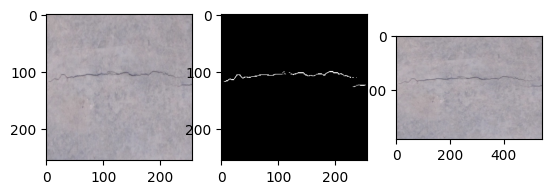

In [24]:
idx = 30

plt.subplot(131)
plt.imshow(train_dataset[idx][0].cpu().detach().numpy().transpose(1, 2, 0))

plt.subplot(132)
plt.imshow(train_dataset[idx][1].cpu().detach().numpy().transpose(1, 2, 0), cmap='gray')

plt.subplot(133)
row = train.reset_index(drop=True).loc[idx].squeeze()
image_path = row['ID']
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
plt.imshow(image)

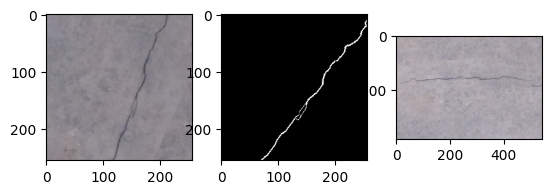

In [25]:
plt.subplot(131)
plt.imshow(rotate_dataset9[idx][0].cpu().detach().numpy().transpose(1, 2, 0))

plt.subplot(132)
plt.imshow(rotate_dataset9[idx][1].cpu().detach().numpy().transpose(1, 2, 0), cmap='gray')

plt.subplot(133)
plt.imshow(image)

In [26]:
# train_dataset = CrackDataset(train)
# colorjitter_dataset = CrackDatasetV2(train, transforms=colorjitter_transforms)
# noise_dataset = CrackDatasetV2(train, transforms=noise_transforms)
# superpixel_dataset = CrackDatasetV2(train, transforms=superpixel_transforms)
# sharpening_dataset = CrackDatasetV2(train, transforms=sharpening_transforms)

valid_dataset = CrackDatasetV2(valid)
test_dataset = CrackDataset(test_files, train_mode=False)

total_dataset = ConcatDataset([train_dataset,rotate_dataset,rotate_dataset1,
                               rotate_dataset2,rotate_dataset3,rotate_dataset4,
                               rotate_dataset5,rotate_dataset6,rotate_dataset7,
                               rotate_dataset8,rotate_dataset9,rotate_dataset10,
                               rotate_dataset11,rotate_dataset12,rotate_dataset13])

train_dataloader = DataLoader(total_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True,
                              collate_fn = train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=CFG["BATCH_SIZE"], shuffle=False,
                              collate_fn=valid_dataset.collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
"""
@torch.no_grad()
def validate_test_image(model, dataset):
  idx = np.random.randint(len(dataset))
  dataset = dataset.reset_index(drop=True)
  row = dataset.loc[idx].squeeze()

  image = cv2.imread(row['ID'])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)
  image = (image/255).astype(np.float32)
  image_tensor = train_transforms(image=image)['image'].unsqueeze(0).to(device)

  mask = cv2.imread(row['label'])
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = cv2.resize(mask, (CFG['IMAGE_SIZE'], CFG['IMAGE_SIZE']))
  _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

  model.eval()
  output = model(image_tensor)
  output = output[0].cpu().detach().numpy().transpose(1, 2, 0)

  # output shape -> (batch_size, channel=2, height, width)
  # output = output.cpu().detach().numpy()
  output = np.where(output[:, :, 0] < output[:, : ,1], 1, 0)
  # output = np.expand_dims(output, axis=1)



  plt.figure(figsize=(8, 4))
  plt.subplot(131)
  plt.title('Original image')
  plt.imshow(image)

  plt.subplot(132)
  plt.title('Original mask')
  plt.imshow(mask, cmap='gray')

  plt.subplot(133)
  plt.title('Predicted mask')
  plt.imshow(output, cmap='gray')

  plt.tight_layout()
  plt.show()
  plt.pause(0.001)
"""

In [37]:
#위에가 원래 승유님꺼
@torch.no_grad()
def validate_test_image(model, dataloader):
    model.eval()
    idx = np.random.randint(0, len(dataloader.dataset))


    images, masks = next(iter(dataloader))
    image = images[idx].unsqueeze(0).to(device)

    outputs = model(image)
    output = outputs[0]


    output = output.cpu().detach().numpy()
    output = output.squeeze()
    mask = masks[idx].cpu().numpy().squeeze()


    image = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    image = np.clip(image, 0, 1)

    plt.figure(figsize=(8, 4))
    plt.subplot(131)
    plt.title('Original image')
    plt.imshow(image)

    plt.subplot(132)
    plt.title('Original mask')
    plt.imshow(mask, cmap='gray')

    plt.subplot(133)
    plt.title('Predicted mask')
    plt.imshow(output, cmap='gray')

    plt.tight_layout()
    plt.show()
    plt.pause(0.001)




In [28]:
#import paddle
#import paddle.nn as nn
#import paddle.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F
import math


#from paddleseg.cvlibs import manager -> 사용 x
#from paddleseg.models import layers
#from paddleseg.utils import utils -> pretrain용

import math


__all__ = ['U2CrackNet']

#===========aspp=================
class ASPPConv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation):
        super(ASPPConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class ASPPPooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        size = x.shape[-2:]
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.relu(self.bn(self.conv(x)))
        return F.interpolate(x, size=size, mode='bilinear', align_corners=False)

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super(ASPP, self).__init__()
        modules = [ASPPConv(in_channels, out_channels, dilation=rate) for rate in atrous_rates]
        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)
        self.project = nn.Sequential(
            nn.Conv2d(len(modules) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5))

    def forward(self, x):
        res = torch.cat([conv(x) for conv in self.convs], dim=1)
        return self.project(res)
#===========aspp=================


"""
class EfficientChannelAttention(nn.Module):
    def __init__(self, gamma=2, b=1, in_channels=128):
        super().__init__()
        t  = int(abs((math.log(in_channels, 2) + b) / gamma))
        k  = t if t % 2 else t + 1
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=int(k / 2), bias_attr=False)

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose([0, 2, 1])).transpose([0, 2, 1]).unsqueeze(-1)
        y = torch.clamp(y, min=0., max=1.)
        return x * y

"""


class EfficientChannelAttention(nn.Module):
    def __init__(self, gamma=2, b=1, in_channels=128):
        super().__init__()
        t = int(abs((math.log(in_channels, 2) + b) / gamma))
        k = t if t % 2 else t + 1
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k, padding=int(k / 2), bias=False)  # bias_attr를 bias로 변경

    def forward(self, x):
        y = self.avg_pool(x)
        # PyTorch 스타일의 텐서 차원 변환
        y = self.conv(y.squeeze(-1).transpose(1, 2)).transpose(1, 2).unsqueeze(-1)
        y = torch.clamp(y, min=0., max=1.)
        return x * y


#@manager.MODELS.add_component
class U2CrackNet(nn.Module):
    """
     The original article refers to
    Yu, Gui, et al. "RUC-Net: A Residual-Unet-Based Convolutional Neural Network for Pixel-Level Pavement Crack Segmentation."
    Sensors 23.1 (2022): 53.
    """

    def __init__(self, num_classes, in_channels=3, pretrained=None):
        super(U2CrackNet, self).__init__()

        self.stage1 = RSU7(in_channels, 16, 64)
        self.pool12 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage2 = RSU6(64, 16, 64)
        self.pool23 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage3 = RSU5(64, 16, 64)
        self.pool34 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage4 = RSU4(64, 16, 64)
        self.pool45 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage5 = RSU4F(64, 16, 64)
        self.pool56 = nn.MaxPool2d(2, stride=2, ceil_mode=True)




        # self.stage6 = RSU4F(64, 16, 64)

        self.stage6 = ASPP(in_channels=64, out_channels=64, atrous_rates=[1, 6, 12, 18])

        """
        self.stage6 = layers.ASPPModule(
            aspp_ratios=[1, 6, 12, 18],
            in_channels=64,
            out_channels=64,
            align_corners=True
        )
        """


        # decoder
        self.stage5d = RSU4F(128, 16, 64)
        self.stage4d = RSU4(128, 16, 64)
        self.stage3d = RSU5(128, 16, 64)
        self.stage2d = RSU6(128, 16, 64)
        self.stage1d = RSU7(128, 16, 64)

        self.side1 = nn.Conv2d(64, num_classes, 3, padding=1)
        self.side2 = nn.Conv2d(64, num_classes, 3, padding=1)
        self.side3 = nn.Conv2d(64, num_classes, 3, padding=1)
        self.side4 = nn.Conv2d(64, num_classes, 3, padding=1)
        self.side5 = nn.Conv2d(64, num_classes, 3, padding=1)
        self.side6 = nn.Conv2d(64, num_classes, 3, padding=1)

        self.efa1 = EfficientChannelAttention(in_channels=num_classes)
        self.efa2 = EfficientChannelAttention(in_channels=num_classes)
        self.efa3 = EfficientChannelAttention(in_channels=num_classes)
        self.efa4 = EfficientChannelAttention(in_channels=num_classes)
        self.efa5 = EfficientChannelAttention(in_channels=num_classes)
        self.efa6 = EfficientChannelAttention(in_channels=num_classes)


        self.outconv = nn.Conv2d(6 * num_classes, num_classes, 1)

        self.pretrained = pretrained
        self.init_weight()

    def forward(self, x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        # print(f'stage5.hx5.shape: {hx.shape}')
        hx = self.pool56(hx5)
        # print(f'stage5.hx.shape: {hx.shape}')
        #stage 6

        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6, hx5)

        #decoder
        hx5d = self.stage5d(torch.cat((hx6up, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.stage4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.stage3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.stage2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.stage1d(torch.cat((hx2dup, hx1), 1))

        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2, d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3, d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4, d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5, d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6, d1)

        d1 = self.efa1(d1)
        d2 = self.efa2(d2)
        d3 = self.efa3(d3)
        d4 = self.efa4(d4)
        d5 = self.efa5(d5)
        d6 = self.efa6(d6)

        d0 = self.outconv(torch.cat((d1, d2, d3, d4, d5, d6), 1))

        # return [d0, d1, d2, d3, d4, d5, d6]
        return [d0]

    def init_weight(self):
        if self.pretrained is not None:
            utils.load_entire_model(self, self.pretrained)


class REBNCONV(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()

        self.conv_s1 = nn.Conv2d(
            in_ch, out_ch, 3, padding=1 * dirate, dilation=1 * dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU()

    def forward(self, x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout


## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src, tar):

    #src = F.upsample(src, size=paddle.shape(tar)[2:], mode='bilinear')
    src = F.interpolate(src, size=tar.size()[2:], mode='bilinear', align_corners=True)

    return src


### RSU-7 ###
class RSU7(nn.Module):  #UNet07DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d = self.rebnconv6d(torch.cat((hx7, hx6), 1))
        hx6dup = _upsample_like(hx6d, hx5)

        hx5d = self.rebnconv5d(torch.cat((hx6dup, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-6 ###
class RSU6(nn.Module):  #UNet06DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)

        hx5d = self.rebnconv5d(torch.cat((hx6, hx5), 1))
        hx5dup = _upsample_like(hx5d, hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-5 ###
class RSU5(nn.Module):  #UNet05DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5, hx4), 1))
        hx4dup = _upsample_like(hx4d, hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-4 ###
class RSU4(nn.Module):  #UNet04DRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4, hx3), 1))
        hx3dup = _upsample_like(hx3d, hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = _upsample_like(hx2d, hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup, hx1), 1))

        return hx1d + hxin


### RSU-4F ###
class RSU4F(nn.Module):  #UNet04FRES(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch * 2, mid_ch, dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch * 2, mid_ch, dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch * 2, out_ch, dirate=1)

    def forward(self, x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4, hx3), dim=1))
        hx2d = self.rebnconv2d(torch.cat((hx3d, hx2), dim=1))
        hx1d = self.rebnconv1d(torch.cat((hx2d, hx1), dim=1))

        return hx1d + hxin

def get_model():
  model = U2CrackNet(num_classes = 1)
  return model.to(device)


model = get_model()


In [29]:
class EarlyStopping:
  def __init__(self, patience=5, min_delta=0, path=CFG['PATH']):
    self.path = path
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = np.inf
    self.early_stop = False

  def __call__(self, val_loss, model=None):
    if self.best_loss - val_loss > self.min_delta:
      torch.save(model.state_dict(), self.path)
      print(f'Model saved to : {self.path}')
      self.best_loss = val_loss
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
      if self.counter >= self.patience:
        print('INFO: Early stopping')
        self.early_stop = True

In [ ]:
"""
from torch.autograd import Variable

class FocalLoss(nn.Module):

    def __init__(self, alpha=1.0, gamma=0, weight=None, size_average=True,
                 weight_ratio=None, label_smoothing=0.0):
        super(FocalLoss, self).__init__()

        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
        self.size_average = size_average
        self.weight_ratio=weight_ratio
        self.label_smoothing = label_smoothing

    def forward(self, input, target):
        if input.dim()>2:
            input = input.contiguous().view(input.size(0), input.size(1), -1)
            input = input.transpose(1, 2)
            input = input.contiguous().view(-1, input.size(2)).squeeze()

        if target.dim()==4:
            target = target.contiguous().view(target.size(0), target.size(1), -1)
            target = target.transpose(1, 2)
            target = target.contiguous().view(-1, target.size(2)).squeeze()
        elif target.dim()==3:
            target = target.view(-1)
        else:
            target = target.view(-1, 1)

        weight = Variable(self.weight)
        logpt = -F.cross_entropy(input, target, weight=self.weight_ratio,
                                 label_smoothing=self.label_smoothing)
        pt = torch.exp(logpt)

        loss = -((1-pt) ** self.gamma) * logpt * self.alpha

        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

"""

In [33]:
import torch.nn.functional as F

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=CFG['LEARNING_RATE'], momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, power=0.9, total_iters=CFG['EPOCHS'])

early=EarlyStopping()

In [31]:
"""
#for focal loss

#criterion = nn.MSELoss()
# criterion = OhemLoss(ratio=0.5)
# criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.1, 3.0].to(device)), label_smoothing=0.2)
# criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.4, 0.6]).to(device))
criterion = FocalLoss(alpha=1.0, gamma=2, size_average=True,
                      #weight=torch.FloatTensor([0.4, 0.6]).to(device),
                     #label_smoothing=0.0)

criterion = FocalLoss(alpha=1.0, gamma=2, size_average=True,
                      #weight=None,
                     #label_smoothing=0.0)


optimizer = torch.optim.SGD(model.parameters(), lr=CFG['LEARNING_RATE'], momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['LEARNING_RATE'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, power=0.9, total_iters=CFG['EPOCHS'])

early=EarlyStopping()
"""

"\n#for focal loss\n\n#criterion = nn.MSELoss()\n# criterion = OhemLoss(ratio=0.5)\n# criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.1, 3.0].to(device)), label_smoothing=0.2)\n# criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.4, 0.6]).to(device))\ncriterion = FocalLoss(alpha=1.0, gamma=2, size_average=True,\n                      #weight=torch.FloatTensor([0.4, 0.6]).to(device),\n                     #label_smoothing=0.0)\n\ncriterion = FocalLoss(alpha=1.0, gamma=2, size_average=True,\n                      #weight=None,\n                     #label_smoothing=0.0)\n\n\noptimizer = torch.optim.SGD(model.parameters(), lr=CFG['LEARNING_RATE'], momentum=0.9, weight_decay=0.0005)\n# optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['LEARNING_RATE'])\n# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)\n# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)\nscheduler = torch.optim.lr_sc

In [46]:
def train_one_batch(batch, model, criterion, optimizer):
    images, masks = batch
    optimizer.zero_grad()
    output = model(images)
    output = output[0].float()
    print(output)
    masks = masks.float()
    loss = criterion(output, masks)
    loss.backward()
    optimizer.step()
    return loss.item()


@torch.no_grad()
def validate_one_batch(batch, model, criterion):
  images, masks = batch
  output = model(images)
  output = output[0].float()
  loss = criterion(output, masks)
  return loss.item()

def validate_one_batch(batch, model):
  images, masks = batch
  output = model(images)
  output = output[0].float()
  loss = criterion(output, masks)
  return loss.item()

In [48]:
train_losses, valid_losses = [], []
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

for epoch in range(CFG['EPOCHS']):
    print(f'Epoch {epoch+1}/{CFG["EPOCHS"]}')
    print('current_lr : ', optimizer.param_groups[0]['lr'])
    epoch_train_losses, epoch_valid_losses = [], []

    model.train()
    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        batch_train_loss = train_one_batch(batch, model, criterion, optimizer)
        epoch_train_losses.append(batch_train_loss)

    epoch_train_loss = np.array(epoch_train_losses).mean()
    train_losses.append(epoch_train_loss)
    print(f"Train loss: {epoch_train_loss:.4f}.")

    model.eval()
    y_true, y_pred = [], []

    for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        images, masks = batch
        outputs = model(images)
        main_output = outputs[0]  # 주 출력 선택
        batch_valid_loss = criterion(main_output, masks)
        epoch_valid_losses.append(batch_valid_loss.item())

        y_true.append(masks.cpu().numpy())
        y_pred.append(main_output.cpu().detach().numpy())

    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(epoch_valid_loss)
    print(f'Valid loss: {epoch_valid_loss:.4f}.')
    print('-' * 50)

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    y_pred = np.where(y_pred > 0.5, 1, 0)  # 이진 분류 임계값 설정

    print('y_true_reshape_before_reshape' , y_true ,'y_pred_reshape_before_reshape',y_pred)

    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)

    y_true_one_valid = []
    y_pred_one_valid = []

    len_one_true = 0
    len_one_pred = 0

    for i in y_true_one_valid:
      if i == 1:
        y_true_one_valid.append(i)
      len_one_true = len(y_true_one_valid)


    for i in y_pred_one_valid:
      if i == 1:
        y_pred_one_valid.append(i)
      len_one_pred = len(y_pred_one_valid)


    print('y_true_reshape' , len_one_true  ,'y_pred_reshape',len_one_true)

    #validate_test_image(model, valid_dataloader)  # 검증 이미지 표시 함수 (정의 필요)
    print('Val F1 Score:', f1_score(y_true, y_pred))
    print('Val Precision:', precision_score(y_true, y_pred))
    print('Val Recall:', recall_score(y_true, y_pred))

    if (epoch % 5 == 0):
        torch.save(model.state_dict(), CFG['PATH'] + f'_{epoch}')

    scheduler.step(epoch)

    # Early stopping 조건 체크 (early stopping 정의 필요)
    # if early.early_stop:
    #     print(f"Validation loss did not improve for {early.patience} epochs. Training stopped.")
    #     model.load_state_dict(torch.load(CFG['PATH']))
    #     break


Epoch 1/45
current_lr :  0.0001


  0%|          | 0/253 [00:00<?, ?it/s]

OutOfMemoryError: ignored

In [ ]:
y_pred = []
my_submission = pd.read_csv(os.path.join(base_path, 'test_files.csv'))

model.eval()
for path, images in tqdm(zip(my_submission['ID'], test_dataloader), total=len(test_dataloader)):
  output = model(images.to(device)).cpu().detach().numpy()

  output = np.where(output[:, 0, :, :] < output[:,1,:,:], 1, 0)
  output = np.expand_dims(output, axis=1)

  output = np.where(output.astype(np.float32) > 0.5, 1, 0)
  output = output[0][0].reshape(-1, )

  img = list(map(int, output.tolist()))
  label = "".join(map(str, img))

  chunk_size = 8
  chunks = [label[i:i+chunk_size] for i in range(0, len(label), chunk_size)]

  for i in range(len(chunks)):
    y_pred.append([path+str(i), "2" + chunks[i]])

In [42]:
#test.pth로 test
y_pred = []

epoch = 30
test_model = get_model()
test_model.load_state_dict(torch.load('/content/pth_folder/segment_model.pth_0'))

my_submission = pd.read_csv(os.path.join(base_path, 'test_files.csv'))
test_model.eval()

for path, images in tqdm(zip(my_submission['ID'], test_dataloader), total=len(test_dataloader)):
  output = test_model(images.to(device)).cpu().detach().numpy()

  output = np.where(output[:, 0, :, :] < output[:,1,:,:], 1, 0)
  output = np.expand_dims(output, axis=1)

  output = np.where(output.astype(np.float32) > 0.5, 1, 0)
  output = output[0][0].reshape(-1, )

  img = list(map(int, output.tolist()))
  label = "".join(map(str, img))

  chunk_size = 8
  chunks = [label[i:i+chunk_size] for i in range(0, len(label), chunk_size)]

  for i in range(len(chunks)):
    y_pred.append([path+str(i), "2" + chunks[i]])

  0%|          | 0/237 [00:00<?, ?it/s]

AttributeError: ignored

In [ ]:
submission = pd.DataFrame(y_pred, columns=['ID', 'label'])
submission['label'] = submission['label'].astype(int)
submission.to_csv('./results.csv', index=False)